In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import csv
import pyiast
import ast



## Adsoorption using AiiDAlab
# Question 1:

AiiDAlab provides multiple ways to study adsorption. The three main type of calculation AiiDAlab uses are: XX, XX and XX

# Question 2:




In [38]:
data = {'Probe radius[A]': [1.525] ,'Density[g/cm^3]':[0.576983], 'Accesible Surface Area[A^2]':[0.0], 'Accessible preocupable volume [A^3]': [13428.1] , 'Porosity': [0.0]}

values= pd.DataFrame(data)
print(values)


   Probe radius[A]  Density[g/cm^3]  Accesible Surface Area[A^2]  \
0            1.525         0.576983                          0.0   

   Accessible preocupable volume [A^3]  Porosity  
0                              13428.1       0.0  


# Question 3

In [39]:
Henry_Co={'molecules': ["CO_2","CH_4"],'Henry coefficients at 300k[mol/kg/Pa]':[0.0, 1.12024e-06]}

henr= pd.DataFrame(Henry_Co)
print(henr)

  molecules  Henry coefficients at 300k[mol/kg/Pa]
0      CO_2                               0.000000
1      CH_4                               0.000001


One can notice that the Henry coefficient for CO_2 is XX than CH_4 at 300 K, this observation comes from the fact that XX. 

# Question 4

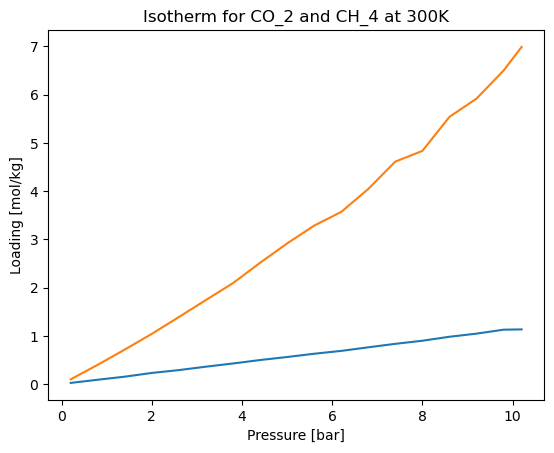

In [40]:
isotherme_ch=dict()
isotherme_co=dict()
with open('CH_4.csv', mode='r', encoding='utf-8') as CH_csv:
    lecteur_CH_csv = csv.reader(CH_csv)

    for index, ligne in enumerate(lecteur_CH_csv):
        if index == 35:
            isotherme_ch = eval(ligne[1])

with open('CO_2.csv', mode='r', encoding='utf-8') as CO_csv:
    lecteur_CO_csv = csv.reader(CO_csv)

    for index, ligne in enumerate(lecteur_CO_csv):
        if index == 35:
            isotherme_co = eval(ligne[1])


pressure_x = isotherme_ch['pressure']
adsorption_ch_4 =isotherme_ch['loading_absolute_average']
adsorption_co_2 = isotherme_co['loading_absolute_average']

plt.plot(pressure_x,adsorption_ch_4, label='CH_4')
plt.plot(pressure_x,adsorption_co_2, label='CO_2')
plt.title("Isotherm for CO_2 and CH_4 at 300K")
plt.xlabel("Pressure [bar]")
plt.ylabel("Loading [mol/kg]")

plt.show()

# Question 5


                      Component 0: p^0 = 10.752822 > 10.200000, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.


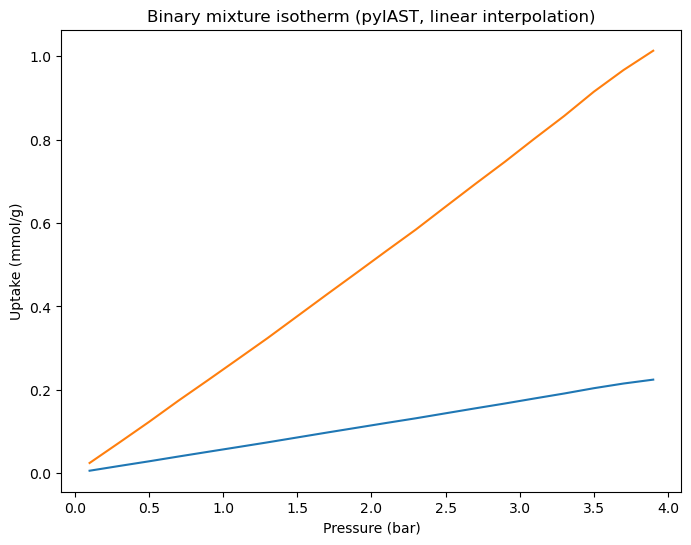

In [41]:
ch_panda=pd.DataFrame({"pressure": pressure_x, "loadings":adsorption_ch_4})
co_panda=pd.DataFrame({"pressure": pressure_x, "loadings":adsorption_co_2})

isotherm1 = pyiast.InterpolatorIsotherm(ch_panda, loading_key="loadings", pressure_key="pressure",fill_value=ch_panda['loadings'].iloc[-1])
isotherm2 = pyiast.InterpolatorIsotherm(co_panda, loading_key="loadings", pressure_key="pressure",fill_value=co_panda['loadings'].iloc[-1])


# === Define binary gas mixture ===
# Example: equimolar feed (50% comp1, 50% comp2)
#one could edit the code to allow the user to choosethe composition of the mixture 
y = [0.5, 0.5]

# Pressure range: 0.1 to 4.0, step 0.2
P_range = np.arange(0.1, 4.0, 0.2)

# Store mixture adsorption results
mixture_loadings = []

for P in P_range:
    res = pyiast.iast(partial_pressures=[P * y[0], P * y[1]],isotherms= [isotherm1, isotherm2])
    mixture_loadings.append(res)

mixture_loadings = np.array(mixture_loadings)

# === Plot results ===
plt.figure(figsize=(8,6))
plt.plot(P_range, mixture_loadings[:,0], label="CH_4 uptake")
plt.plot(P_range, mixture_loadings[:,1], label="C0_2 uptake")
plt.xlabel("Pressure (bar)")
plt.ylabel("Uptake (mmol/g)")
plt.title("Binary mixture isotherm (pyIAST, linear interpolation)")
plt.show()

# Question 6

In [7]:
# Load CSV files (adjust file names if needed)
file_co2 = "CO_2.csv"
file_ch4 = "CH_4.csv"

df_co2 = pd.read_csv(file_co2)
df_ch4 = pd.read_csv(file_ch4)

# Parse isotherm strings
iso_co2 = ast.literal_eval(df_co2.loc[df_co2["Key"]=="isotherm","Value"].values[0])
iso_ch4 = ast.literal_eval(df_ch4.loc[df_ch4["Key"]=="isotherm","Value"].values[0])

pressures_co2 = np.array(iso_co2["pressure"])
loadings_co2 = np.array(iso_co2["loading_absolute_average"])
pressures_ch4 = np.array(iso_ch4["pressure"])
loadings_ch4 = np.array(iso_ch4["loading_absolute_average"])

# Henry coefficients
K_CO2 = float(df_co2.loc[df_co2["Key"]=="henry_coefficient_average","Value"].values[0])
K_CH4 = float(df_ch4.loc[df_ch4["Key"]=="henry_coefficient_average","Value"].values[0])

Formula:

$
S_{CO_2/CH_4} = \frac{q_{CO_2}}{q_{CH_4}} \cdot \frac{y_{CH_4}}{y_{CO_2}}
$

We compute at 0.1, 1, 2, 3 bar for y_CO_2 = y_CH_4 = 0.5.

In [8]:
def uptake(pressures, loadings, P, K):
    """Return uptake (mmol/g) at pressure P (bar)."""
    if P < pressures.min():
        return K * P * 1e5  # Henry extrapolation (Pa)
    return np.interp(P, pressures, loadings)

def selectivity(P, y_CO2=0.5, y_CH4=0.5):
    q_CO2 = uptake(pressures_co2, loadings_co2, P, K_CO2)
    q_CH4 = uptake(pressures_ch4, loadings_ch4, P, K_CH4)
    S = (q_CO2/q_CH4)*(y_CH4/y_CO2)
    return q_CO2, q_CH4, S

pressures = [0.1, 1.0, 2.0, 3.0]
results_q6 = []
for P in pressures:
    q_co2, q_ch4, S = selectivity(P)
    results_q6.append({"P(bar)":P,"q_CO2(mmol/g)":q_co2,"q_CH4(mmol/g)":q_ch4,"S":S})

df_q6 = pd.DataFrame(results_q6)
df_q6

,P(bar),q_CO2(mmol/g),q_CH4(mmol/g),S
0,0.1,0.049551,0.011202,4.423275
1,1.0,0.505522,0.111529,4.532654
2,2.0,1.042105,0.231175,4.507865
3,3.0,1.625821,0.337303,4.820060


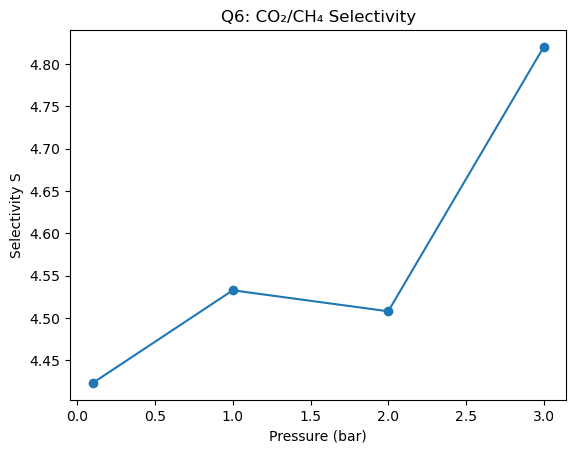

In [9]:
# Plot selectivity vs P
plt.figure()
plt.plot(df_q6["P(bar)"], df_q6["S"], marker="o")
plt.xlabel("Pressure (bar)")
plt.ylabel("Selectivity S")
plt.title("Q6: CO₂/CH₄ Selectivity")
plt.show()

# Question 7

At low P (Henry regime):
$$
q_i = K_i \, y_i \, P \quad \Rightarrow \quad S = \frac{K_{CO₂}}{K_{CH₄}}
$$
So S does not depend on composition.

We check numerically at P = 0.1 bar for two gas mixtures.

In [ ]:
P_test = 0.1
for (y_CO2, y_CH4) in [(0.5,0.5),(0.2,0.8)]:
    q_co2, q_ch4, S = selectivity(P_test, y_CO2, y_CH4)
    print(f"y_CO2={y_CO2}, y_CH4={y_CH4} -> S = {S:.4f}")

print(f"S from Henry constants = {K_CO2/K_CH4:.4f}")

**Discussion Q7**  
- Numerical check confirms S is the same for y_CO₂ = 0.5 or 0.2 at low P.  
- Analytically, S = K_CO₂/K_CH₄, independent of composition.  
- To test temperature effect: compute isotherms at another T (e.g. 280 K, 320 K) and recalc S(T). If S changes with T, selectivity depends on temperature.

# Question 8

We examine the pure CH₄ isotherm and comment on storage potential.

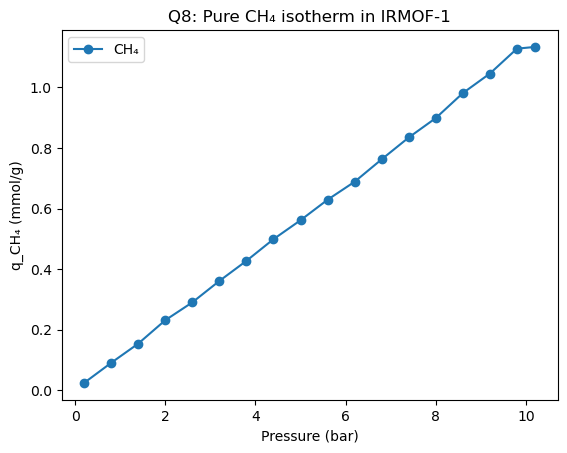

In [10]:
plt.figure()
plt.plot(pressures_ch4, loadings_ch4, marker="o", label="CH₄")
plt.xlabel("Pressure (bar)")
plt.ylabel("q_CH₄ (mmol/g)")
plt.title("Q8: Pure CH₄ isotherm in IRMOF-1")
plt.legend()
plt.show()

**Discussion Q8**  
- CH₄ uptake is modest compared to CO₂.  
- IRMOF-1 shows weak CH₄ interactions → low working capacity.  
- Therefore, IRMOF-1 is **not a good candidate** for CH₄ storage, though it works better for CO₂/CH₄ separation.